In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error

In [2]:
train = pd.read_csv('data/Predicting-House-Prices-In-Bengaluru-Train-Data.csv')
test = pd.read_csv('data/Predicting-House-Prices-In-Bengaluru-Test-Data.csv')

print("Data info: {train} training obs and {test} testing observations".format(train=train.shape, test=test.shape))

Data info: (13320, 9) training obs and (1480, 9) testing observations


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
area_type       13320 non-null object
availability    13320 non-null object
location        13319 non-null object
size            13304 non-null object
society         7818 non-null object
total_sqft      13320 non-null object
bath            13247 non-null float64
balcony         12711 non-null float64
price           13320 non-null float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 9 columns):
area_type       1480 non-null object
availability    1480 non-null object
location        1480 non-null object
size            1478 non-null object
society         854 non-null object
total_sqft      1480 non-null object
bath            1473 non-null float64
balcony         1411 non-null float64
price           0 non-null float64
dtypes: float64(3), object(6)
memory usage: 104.2+ KB


In [5]:
num_const_imputer = SimpleImputer(strategy='constant', fill_value=2.0)
cat_const_imputer = SimpleImputer(strategy='constant', fill_value='unknown')

In [6]:
for c in ['bath', 'balcony']:
    train[c] = num_const_imputer.fit_transform(train[c].values.reshape(-1,1))
    test[c] = num_const_imputer.fit_transform(test[c].values.reshape(-1,1))

for c in ['size', 'society', 'location']:
    train[c] = cat_const_imputer.fit_transform(train[c].values.reshape(-1,1))
    test[c] = cat_const_imputer.fit_transform(test[c].values.reshape(-1,1))

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 9 columns):
area_type       1480 non-null object
availability    1480 non-null object
location        1480 non-null object
size            1480 non-null object
society         1480 non-null object
total_sqft      1480 non-null object
bath            1480 non-null float64
balcony         1480 non-null float64
price           0 non-null float64
dtypes: float64(3), object(6)
memory usage: 104.2+ KB


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
area_type       13320 non-null object
availability    13320 non-null object
location        13320 non-null object
size            13320 non-null object
society         13320 non-null object
total_sqft      13320 non-null object
bath            13320 non-null float64
balcony         13320 non-null float64
price           13320 non-null float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [9]:
X_train_baseline = train.copy()
X_test_baseline = test.copy()

X_test_baseline.drop(['price'], axis=1, inplace=True)

In [10]:
# Baseline is a quickie!
# All the rows having missing values would be removed.

X_train_baseline.dropna(inplace=True)
X_test_baseline.dropna(inplace=True)

print("Baseline data info: {train} training obs and {test} testing observations".format(train=X_train_baseline.shape, test=X_test_baseline.shape))

Baseline data info: (13320, 9) training obs and (1480, 8) testing observations


In [11]:
X_train_baseline.head(7)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,unknown,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,unknown,1200,2.0,1.0,51.00
5,Super built-up Area,Ready To Move,Whitefield,2 BHK,DuenaTa,1170,2.0,1.0,38.00
6,Super built-up Area,18-May,Old Airport Road,4 BHK,Jaades,2732,4.0,2.0,204.00


In [12]:
# checking if both train/test set have the same set of uniques.

def print_value_counts(df, cols):
    
    for col in cols:
        print(df[col].value_counts())
        print('\n\n')

In [13]:
# reduce levels for availability, size

def replace_values(df, colname, default_str='NA', replace_str='NA', alter=False, index=0, pat=None, 
                   astype='int64'):
    if alter:
        if pat:
            df[colname] = df[colname].str.extract(pat=pat, expand=True)[index]
            df[colname] = df[colname].astype(astype)
        else:
            df[colname] = df[colname].apply(lambda x: '2' if x == 'unknown' else x)
            
            df[colname] = df[colname].str.split(expand=True)[index]
            df[colname] = df[colname].astype(astype)
    else:
        df[colname] = df[colname].apply(lambda x: replace_str if x != default_str else x)
    
    return df    

In [14]:
X_train_baseline = replace_values(X_train_baseline, 'availability', 'Ready To Move', 'Not Ready')
X_test_baseline = replace_values(X_test_baseline, 'availability', 'Ready To Move', 'Not Ready')

In [15]:
X_train_baseline = replace_values(X_train_baseline, 'size', alter=True, index=0)
X_test_baseline = replace_values(X_test_baseline, 'size', alter=True, index=0)

In [16]:
pattern = '(\d+)'

X_train_baseline = replace_values(X_train_baseline, 'total_sqft', alter=True, index=0, pat=pattern)
X_test_baseline = replace_values(X_test_baseline, 'total_sqft', alter=True, index=0, pat=pattern)

In [17]:
X_train_baseline.head(7)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,Not Ready,Electronic City Phase II,2,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3,unknown,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2,unknown,1200,2.0,1.0,51.00
5,Super built-up Area,Ready To Move,Whitefield,2,DuenaTa,1170,2.0,1.0,38.00
6,Super built-up Area,Not Ready,Old Airport Road,4,Jaades,2732,4.0,2.0,204.00


In [18]:
X_test_baseline.head(4)

,area_type,availability,location,size,society,total_sqft,bath,balcony
0,Super built-up Area,Ready To Move,Brookefield,2,Roeekbl,1225,2.0,2.0
1,Plot Area,Ready To Move,Akshaya Nagar,9,unknown,2400,9.0,2.0
2,Plot Area,Not Ready,Hennur Road,4,Saandtt,1650,5.0,2.0
3,Super built-up Area,Ready To Move,Kodichikkanahalli,3,Winerri,1322,3.0,1.0


In [19]:
print_value_counts(X_train_baseline, cols=X_train_baseline.select_dtypes(include=['object']).columns)

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64



Ready To Move    10581
Not Ready         2739
Name: availability, dtype: int64



Whitefield         540
Sarjapur  Road     399
Electronic City    302
Kanakpura Road     273
Thanisandra        234
                  ... 
Gollarahatti         1
Wheelers Road        1
Kudlu Village,       1
BEL Layout           1
KG Halli             1
Name: location, Length: 1306, dtype: int64



unknown    5502
GrrvaGr      80
PrarePa      76
Sryalan      59
Prtates      59
           ... 
NStusD        1
Elacet        1
Ozdiaan       1
Vaarai        1
WoarkEm       1
Name: society, Length: 2689, dtype: int64





In [20]:
print_value_counts(X_test_baseline, cols=X_test_baseline.select_dtypes(include=['object']).columns)

Super built-up  Area    946
Built-up  Area          270
Plot  Area              254
Carpet  Area             10
Name: area_type, dtype: int64



Ready To Move    1162
Not Ready         318
Name: availability, dtype: int64



Whitefield                    51
Thanisandra                   43
Sarjapur  Road                38
Electronic City               35
Kanakpura Road                25
                              ..
Nagappa Reddy Layout           1
Ashwini layout                 1
near ullas theater             1
Hegganahalli                   1
Yemlur, Old Airport Road,      1
Name: location, Length: 495, dtype: int64



unknown    626
GrrvaGr     12
Bhmesy      12
Soitya       9
Prarkun      8
          ... 
Jar 1 S      1
HoAcela      1
YMarlti      1
Saowson      1
KPareis      1
Name: society, Length: 595, dtype: int64





In [21]:
# society, location have different numbers for levels. 
# combining both to fit a LabelEncoder would be the way.
cols = ['area_type', 'availability', 'society', 'location']
combined_df = pd.concat([X_train_baseline[cols], X_test_baseline[cols]], 
                        axis=0)
combined_df.shape

(14800, 4)

In [22]:
lbl_encoder = LabelEncoder()

In [23]:
for c in cols:
    lbl_encoder.fit(combined_df[c])
    
    X_train_baseline[c] = lbl_encoder.transform(X_train_baseline[c])
    X_test_baseline[c] = lbl_encoder.transform(X_test_baseline[c])
    

In [24]:
X_train_baseline.head(5)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,3,0,430,2,487,1056,2.0,1.0,39.07
1,2,1,325,4,2568,2600,5.0,3.0,120.00
2,0,1,1219,3,2832,1440,2.0,3.0,62.00
3,3,1,778,3,2302,1521,3.0,1.0,95.00
4,3,1,736,2,2832,1200,2.0,1.0,51.00


In [25]:
X_test_baseline.head(5)

,area_type,availability,location,size,society,total_sqft,bath,balcony
0,3,1,284,2,1875,1225,2.0,2.0
1,2,1,103,9,2832,2400,9.0,2.0
2,2,0,534,4,2029,1650,5.0,2.0
3,3,1,721,3,2816,1322,3.0,1.0
4,3,1,727,2,135,1161,2.0,1.0


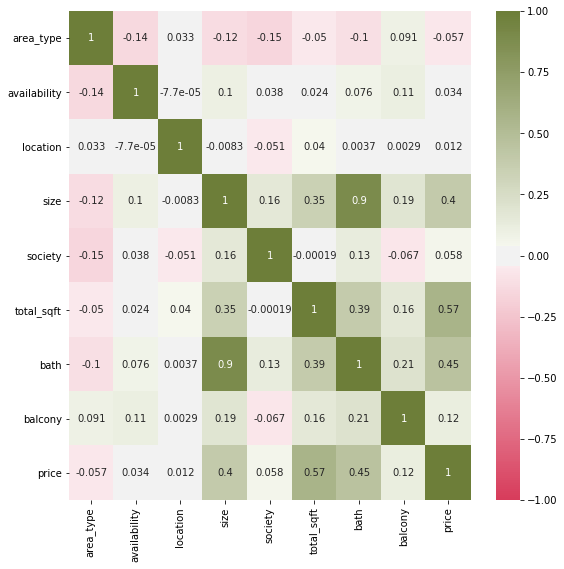

In [26]:
%matplotlib inline
plt.figure(figsize=(9,9))
cmap = sns.diverging_palette(5,100, as_cmap=True)
sns.heatmap(X_train_baseline.corr(), vmin=-1, vmax=1, cmap=cmap, annot=True)

In [27]:
# correlations

# size --> bath, total_sqft
# total_sqft --> bath

# this is multicollinearity of sorts!
# But the pick among these is, total_sqft ; it's the most correlated with price

# so, removing bath, size from the set of features.

feature_subset = X_train_baseline.drop(['size', 'bath', 'price'], axis=1).columns

In [28]:
X = X_train_baseline.drop(['price'], axis=1)
y = X_train_baseline['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape)

(10656, 8) (2664, 8)


In [29]:
scaler = StandardScaler()

In [30]:
model = GradientBoostingRegressor()
param_grid = {"learning_rate":[0.1, 0.07, 0.05], "max_depth":[3,4], "n_estimators":[100,200,300,400,500]}

grid_model = GridSearchCV(model, param_grid=param_grid, n_jobs=-1, verbose=2)

In [31]:
clf_pipeline = Pipeline(steps=[('scaler', scaler), ('clf', grid_model)], verbose=True)

In [32]:
clf_pipeline.fit(X_train, y_train)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.5min finished


[Pipeline] ............... (step 2 of 2) Processing clf, total= 2.6min


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 GridSearchCV(cv=None, error_score=nan,
                              estimator=GradientBoostingRegressor(alpha=0.9,
                                                                  ccp_alpha=0.0,
                                                                  criterion='friedman_mse',
                                                                  init=None,
                                                                  learning_rate=0.1,
                                                                  loss='ls',
                                                                  max_depth=3,
                                                                  max_features=None,
                                                                  max_leaf_nodes=None,
                                                       

In [33]:
y_pred = clf_pipeline.predict(X_test)

In [34]:
clf_pipeline.fit(X_train[feature_subset], y_train)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.2min finished


[Pipeline] ............... (step 2 of 2) Processing clf, total= 2.3min


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 GridSearchCV(cv=None, error_score=nan,
                              estimator=GradientBoostingRegressor(alpha=0.9,
                                                                  ccp_alpha=0.0,
                                                                  criterion='friedman_mse',
                                                                  init=None,
                                                                  learning_rate=0.1,
                                                                  loss='ls',
                                                                  max_depth=3,
                                                                  max_features=None,
                                                                  max_leaf_nodes=None,
                                                       

In [36]:
y_pred = clf_pipeline.predict(X_test[feature_subset])
# mean_squared_log_error(y_test, y_pred)

In [37]:
clf_pipeline.fit(X[feature_subset], y)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.8min finished


[Pipeline] ............... (step 2 of 2) Processing clf, total= 2.9min


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 GridSearchCV(cv=None, error_score=nan,
                              estimator=GradientBoostingRegressor(alpha=0.9,
                                                                  ccp_alpha=0.0,
                                                                  criterion='friedman_mse',
                                                                  init=None,
                                                                  learning_rate=0.1,
                                                                  loss='ls',
                                                                  max_depth=3,
                                                                  max_features=None,
                                                                  max_leaf_nodes=None,
                                                       

In [38]:
y_pred = clf_pipeline.predict(X_test_baseline[feature_subset])

In [39]:
test.drop(['price'], axis=1, inplace=True)
test['price'] = y_pred

test = test.round(2)
test.head(4)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,1225,2.0,2.0,67.72
1,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,unknown,2400,9.0,2.0,285.90
2,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,2.0,174.30
3,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0,65.76


In [40]:
# !pip install openpyxl
test.to_excel('data/submission.xlsx', index=False)